# Exercise 8. Text Analytics in Social Media 

In this exercise we will be using the Twitter US Airline Sentiment data set on Kaggle https://www.kaggle.com/crowdflower/twitter-airline-sentiment for Twitter sentiment analysis. We will first clean the data and then apply two well-known NLP packages for sentiment analysis. After that, we will train our own supervised and unsupervised sentiment analysis classifiers. The steps will be:

1. Data cleaning
2. Sentiment analysis with NLP packages
        2.1. textblob
        2.2. VADER
3. Supervised sentiment classifier
4. Unsupervised sentiment classifier

In [1]:
!pip install tweet-preprocessor

In [2]:
# Import packages
import numpy as np 
np.random.seed(37)
import pandas as pd 
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from seaborn import countplot, distplot, heatmap
from preprocessor.api import clean
import inspect
import preprocessor
import nltk
nltk.download('vader_lexicon')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Import data
df = pd.read_csv('/content/drive/MyDrive/TWSM_Data/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


The data presents the Tweets for six US airlines in February 2015 together with their sentiment (added, not part of Twitter data), confidence in the sentiment and if applicable a reason for negative sentiment and the corresponding confidence.

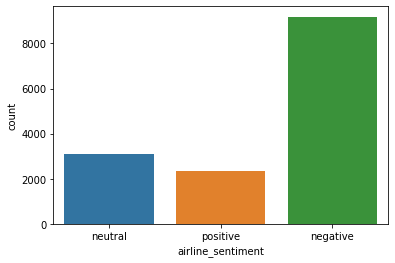

In [5]:
# Examine sentiment class distribution
countplot(x="airline_sentiment", data=df)

There are three possible sentiment classes and most of the data is negative.

## 1. Data preprocessing

Cleaning Twitter data requires more effort than cleaning other sources such as news or books, because tweets contain different additional parts such as emojis and hashtags.

In [6]:
# Data preprocessing
df['prep']=[clean(doc) for doc in df['text']]

Below in the code you can see the preprocessing steps.

In [7]:
#print(inspect.getsource(preprocessor.preprocess))
print(inspect.getsource(preprocessor.defines.Patterns))
#print(inspect.getsource(preprocessor.defines))
#print(inspect.getsource(preprocessor.clean))
''' opts = {
    'URL': 'urls',
    'MENTION': 'mentions',
    'HASHTAG': 'hashtags',
    'RESERVED': 'reserved_words',
    'EMOJI': 'emojis',
    'SMILEY': 'smileys',
    'NUMBER':  'numbers',
    'ESCAPE_CHAR': 'escape_chars'
} '''

class Patterns:
    URL_PATTERN_STR = r"""(?i)((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info
                      |int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|
                      bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|
                      cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|
                      gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|
                      la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|
                      nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|
                      sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx

" opts = {\n    'URL': 'urls',\n    'MENTION': 'mentions',\n    'HASHTAG': 'hashtags',\n    'RESERVED': 'reserved_words',\n    'EMOJI': 'emojis',\n    'SMILEY': 'smileys',\n    'NUMBER':  'numbers',\n    'ESCAPE_CHAR': 'escape_chars'\n} "

In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,prep
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),What said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experienc...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),I didn't today... Must mean I need to take ano...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""ent..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


## 2. Sentiment analysis with NLP packages

### 2.1. Textblob

Textblob provides two values: polarity and subjectivity. Here, we will use only polarity.

In [9]:
df['sentiment_tb'] = df['prep'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)

In [10]:
df['sentiment_tb'].describe()

count    14640.000000
mean         0.053555
std          0.320756
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.000000
Name: sentiment_tb, dtype: float64

In [11]:
df['sentiment_tb_desc']=df['sentiment_tb'].apply(lambda x: 'positive' if x>0.5 else ('negative' if x < -0.5 else 'neutral'))

In [12]:
print(classification_report(df['airline_sentiment'], df['sentiment_tb_desc']))

              precision    recall  f1-score   support

    negative       0.95      0.06      0.11      9178
     neutral       0.22      0.94      0.36      3099
    positive       0.55      0.24      0.34      2363

    accuracy                           0.27     14640
   macro avg       0.57      0.41      0.27     14640
weighted avg       0.73      0.27      0.20     14640



Accuracy of 27% is quite low with 33% random accuracy. It seems that it comes from badly classifying the 'negative' class which contains the majority of cases.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

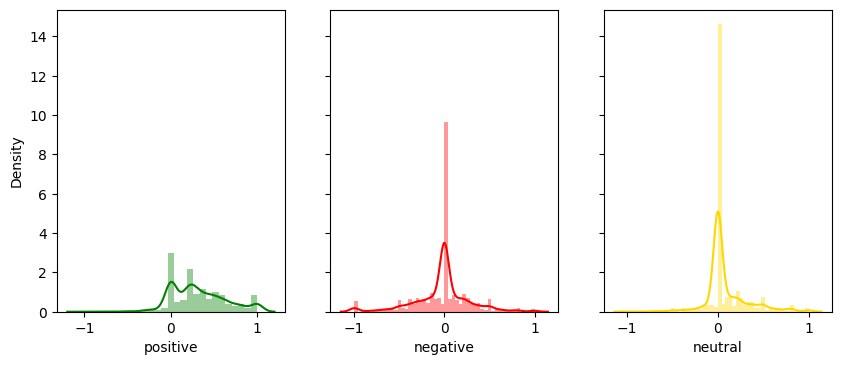

In [13]:
# Distribution of the textblob values for different true setiment classes
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=100)
distplot(df.loc[df.airline_sentiment=='positive', "sentiment_tb"]  , color="green", ax=axes[0], axlabel='positive')
distplot(df.loc[df.airline_sentiment=='negative', "sentiment_tb"] , color="red", ax=axes[1], axlabel='negative')
distplot(df.loc[df.airline_sentiment=='neutral', "sentiment_tb"] , color="gold", ax=axes[2], axlabel='neutral')

'Positive' is well represented as there values are mostly greater than zero. 'Neutral' is also well represented as the values there peak at zero. 'Negative' is badly represented as it is not distributed in the negative values, but everywhere. This confirms the results from the classification report.

## 2.2. Sentiment analysis with VADER

VADER produces four values: negative, neutral, positive and compound. Compound is a combined score of negative and positive.

In [14]:
# Initialise method
sid = SentimentIntensityAnalyzer()

In [15]:
sid.polarity_scores('nice')

{'compound': 0.4215, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0}

In [16]:
df['sentiment_vd'] = df['prep'].apply(lambda tweet: sid.polarity_scores(tweet)['compound'])

In [17]:
df['sentiment_vd'].describe()

count    14640.000000
mean         0.051338
std          0.452522
min         -0.966800
25%         -0.296000
50%          0.000000
75%          0.421500
max          0.976000
Name: sentiment_vd, dtype: float64

In [18]:
df['sentiment_vd_desc']=df['sentiment_vd'].apply(lambda x: 'positive' if x>0.5 else ('negative' if x < -0.5 else 'neutral'))

In [19]:
print(classification_report(df['airline_sentiment'], df['sentiment_vd_desc']))

              precision    recall  f1-score   support

    negative       0.95      0.21      0.34      9178
     neutral       0.26      0.81      0.39      3099
    positive       0.49      0.58      0.53      2363

    accuracy                           0.40     14640
   macro avg       0.56      0.53      0.42     14640
weighted avg       0.73      0.40      0.38     14640



Better than textblob, but still not so gut for 'negative' and 'neutral'-> change 0.5 as a threshold.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

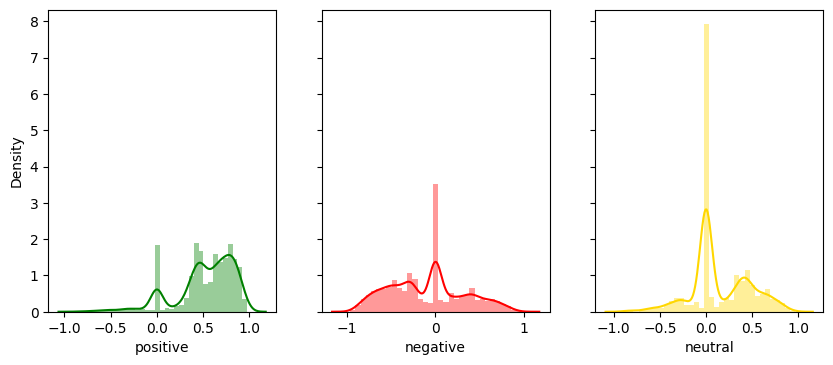

In [20]:
# Distribution of the textblob values for different true setiment classes
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, dpi=100)
distplot(df.loc[df.airline_sentiment=='positive', "sentiment_vd"]  , color="green", ax=axes[0], axlabel='positive')
distplot(df.loc[df.airline_sentiment=='negative', "sentiment_vd"] , color="red", ax=axes[1], axlabel='negative')
distplot(df.loc[df.airline_sentiment=='neutral', "sentiment_vd"] , color="gold", ax=axes[2], axlabel='neutral')

Confirms classification report.

# 3. Supervised sentiment classifier

Can we do better than Vader and Textblob by training a supervised model based on the 'airline_sentiment' column? In the following we will use a bag-of-words documnet representation in combination with a random forest classifier.

In [21]:
# Initialise the transformer
vec=TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words='english')

# Apply it to the training data
tf=vec.fit_transform(df.prep)

In [22]:
# Split data into training and test sets
docs_train, docs_test, y_train, y_test = train_test_split(tf, df.airline_sentiment, 
                                                          test_size = 0.20, random_state = 12)

In [23]:
# Parameter grid
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5],
    'n_estimators': [10,50,100, 200, 300, 1000]
}

In [25]:
# Create a based model
rf = RandomForestClassifier(random_state = 42)# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)
grid_search.fit(docs_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [28]:
best_grid = grid_search.best_estimator_
y_pred = best_grid.predict(docs_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.78      0.87      0.82      1876
     neutral       0.49      0.42      0.45       569
    positive       0.71      0.51      0.59       483

    accuracy                           0.72      2928
   macro avg       0.66      0.60      0.62      2928
weighted avg       0.71      0.72      0.71      2928



The model greatly outperforms the results from the sentiment packages. As opposed to them it shows the best performance on the 'negative' class (due to data imbalancing).

# 4. Unsupervised sentiment classifier

We will use a tf-idf k-means clustering approach here.

In [29]:
#setup kmeans clustering
kmeans = KMeans(n_clusters = 3, max_iter = 200, random_state=42)
vec=TfidfVectorizer(max_df=0.99, min_df=0.01, stop_words='english')
kmeans.fit(vec.fit_transform(df['prep']))
words = vec.get_feature_names()
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : thank, service, just, customer, help, flights, time, plane, amp, hold
1 : thanks, flight, just, great, service, help, got, response, guys, time
2 : flight, cancelled, flightled, delayed, late, hours, time, help, just, flighted


Cluster 2 seems to be negative, cluster 1 positive and cluster 0 not clear.

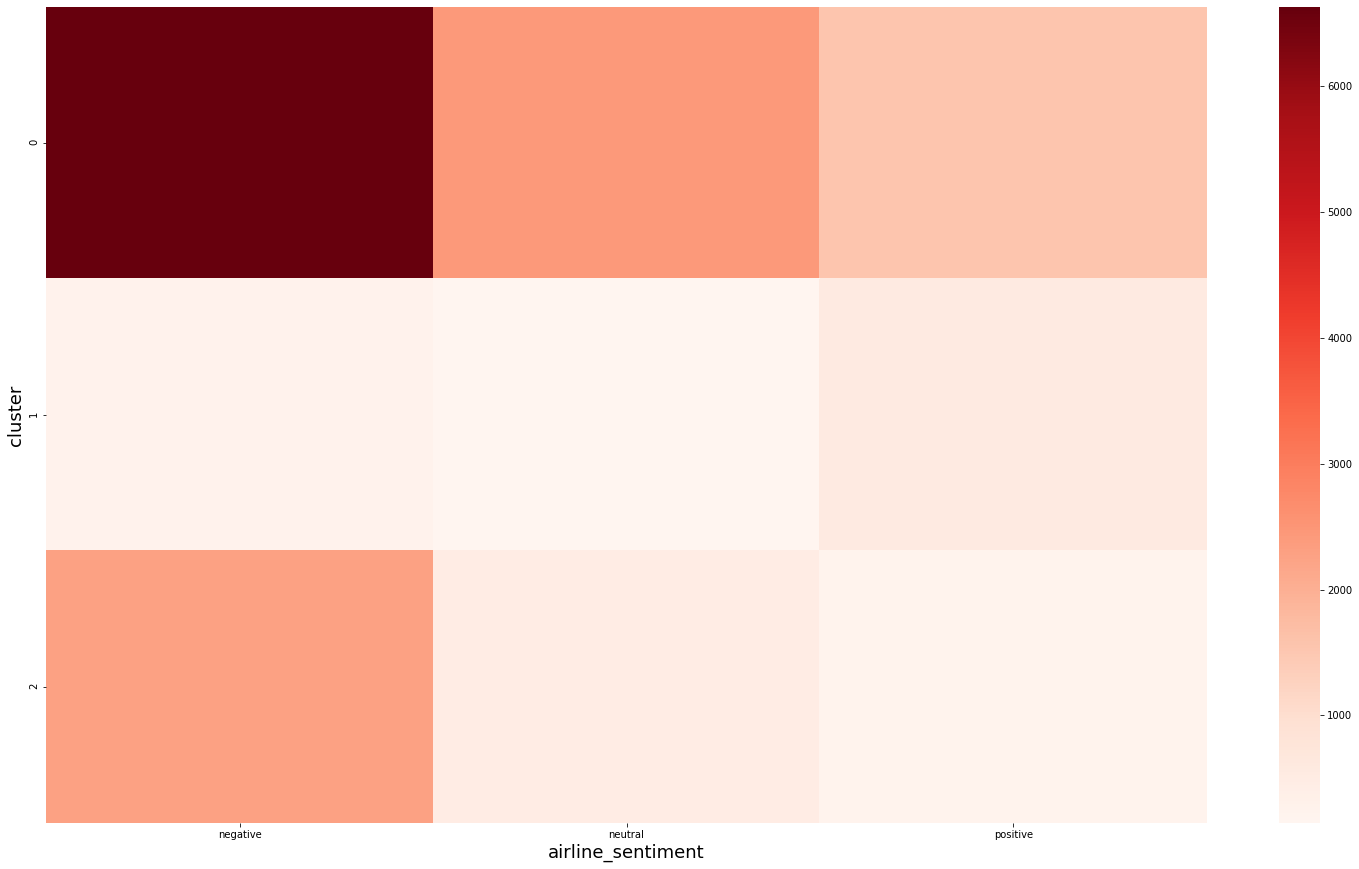

In [30]:
df['cluster'] = kmeans.labels_
clusters = df.groupby(['cluster', 'airline_sentiment']).size()

fig, ax1 = plt.subplots(figsize = (26, 15))
heatmap(clusters.unstack(level = 'airline_sentiment'), ax = ax1, cmap = 'Reds')

ax1.set_xlabel('airline_sentiment').set_size(18)
ax1.set_ylabel('cluster').set_size(18)

Not really clear and not much in accordance with the cluster centers, may be for the positive one.

In [32]:
df['kmeans']=df['cluster'].apply(lambda x: 'negative' if x==2 else ('positive' if x==1 else 'neutral'))

In [33]:
print(classification_report(df['airline_sentiment'], df['kmeans']))

              precision    recall  f1-score   support

    negative       0.76      0.25      0.38      9178
     neutral       0.23      0.79      0.36      3099
    positive       0.58      0.24      0.34      2363

    accuracy                           0.36     14640
   macro avg       0.52      0.43      0.36     14640
weighted avg       0.62      0.36      0.37     14640



Overall not good performance, similar to textblob. Class neutral has low precision, high recall, the other classes show opposite behaviour.